In [45]:
# Export outlier details to CSV for action
outlier_df.to_csv('/home/pvlakehouse/dlh-pv/outlier_report.csv', index=False)

# Generate SQL statements for exclusion
print("\n" + "=" * 100)
print("🔧 SQL STATEMENTS FOR RECORD EXCLUSION")
print("=" * 100)

# Get unique dates for night anomalies
if len(night_anomalies) > 0:
    print("\n-- Exclude night-time high energy records:")
    print("-- SQL: Add these to quality_issues in hourly_energy")
    print(f"-- Count: {len(night_anomalies)} records")

if len(zero_daytime) > 0:
    print("\n-- Exclude daytime zero-energy with high radiation:")
    print("-- SQL: Mark quality_flag as CAUTION in hourly_energy")
    print(f"-- Count: {len(zero_daytime)} records")

# Summary statistics
print("\n" + "=" * 100)
print("📁 Files saved:")
print("=" * 100)
print("  ✓ /home/pvlakehouse/dlh-pv/energy_radiation_divergence.html")
print("  ✓ /home/pvlakehouse/dlh-pv/energy_vs_radiation_scatter.html")
print("  ✓ /home/pvlakehouse/dlh-pv/statistical_boxplots.png")
print("  ✓ /home/pvlakehouse/dlh-pv/diurnal_patterns.png")
print("  ✓ /home/pvlakehouse/dlh-pv/correlation_matrix.png")
print("  ✓ /home/pvlakehouse/dlh-pv/outlier_report.csv")
print("\n✅ Analysis complete!")


🔧 SQL STATEMENTS FOR RECORD EXCLUSION

-- Exclude night-time high energy records:
-- SQL: Add these to quality_issues in hourly_energy
-- Count: 121 records

-- Exclude daytime zero-energy with high radiation:
-- SQL: Mark quality_flag as CAUTION in hourly_energy
-- Count: 231 records

📁 Files saved:
  ✓ /home/pvlakehouse/dlh-pv/energy_radiation_divergence.html
  ✓ /home/pvlakehouse/dlh-pv/energy_vs_radiation_scatter.html
  ✓ /home/pvlakehouse/dlh-pv/statistical_boxplots.png
  ✓ /home/pvlakehouse/dlh-pv/diurnal_patterns.png
  ✓ /home/pvlakehouse/dlh-pv/correlation_matrix.png
  ✓ /home/pvlakehouse/dlh-pv/outlier_report.csv

✅ Analysis complete!


In [44]:
# Generate quality summary and recommendations
print("\n" + "=" * 100)
print("📊 DATA QUALITY SUMMARY & RECOMMENDATIONS")
print("=" * 100)

total_records = len(merged_df)
quality_scores = {
    'GOOD': (merged_df['quality_flag_energy'] == 'GOOD').sum(),
    'CAUTION': (merged_df['quality_flag_energy'] == 'CAUTION').sum(),
    'REJECT': (merged_df['quality_flag_energy'] == 'REJECT').sum()
}

print("\n1️⃣ OVERALL DATA QUALITY:")
for flag, count in quality_scores.items():
    pct = (count / total_records) * 100
    print(f"   {flag}: {count:,} records ({pct:.2f}%)")

print("\n2️⃣ PHYSICAL LIMIT VIOLATIONS:")
total_violations = sum(v['total'] for v in violations.values())
print(f"   Total violations: {total_violations:,} ({(total_violations/total_records)*100:.2f}%)")
for col, viol in violations.items():
    print(f"   - {col}: {viol['total']:,} ({viol['pct']:.2f}%)")

print("\n3️⃣ STATISTICAL OUTLIERS (IQR Method):")
total_iqr_outliers = sum(s['outliers_iqr'] for s in stats_analysis.values())
print(f"   Total outliers: {total_iqr_outliers:,} ({(total_iqr_outliers/total_records)*100:.2f}%)")
for col, stats in stats_analysis.items():
    print(f"   - {col}: {stats['outliers_iqr']:,} ({stats['pct_outliers_iqr']:.2f}%)")

print("\n4️⃣ DIURNAL PATTERN ANOMALIES:")
total_diurnal = sum(len(a) for a in anomalies.values())
print(f"   Total anomalies: {total_diurnal:,} ({(total_diurnal/total_records)*100:.2f}%)")
for anomaly_type, anomaly_data in anomalies.items():
    pct = (len(anomaly_data) / total_records) * 100
    print(f"   - {anomaly_type}: {len(anomaly_data):,} ({pct:.2f}%)")

print("\n5️⃣ DIVERGENCE ANALYSIS:")
if 'divergence' in merged_df.columns:
    high_div_count = (merged_df['divergence'] > 0.3).sum()
    print(f"   High divergence (>0.3): {high_div_count:,} ({(high_div_count/len(merged_df))*100:.2f}%)")
    print(f"   Mean divergence: {merged_df['divergence'].mean():.4f}")
else:
    print(f"   Divergence analysis not available in merged_df")

print("\n6️⃣ RECOMMENDATIONS FOR IMPROVEMENT:")
recommendations = [
    f"1. REJECT {quality_scores['REJECT']:,} records with explicit quality flag = 'REJECT'",
    f"2. INVESTIGATE {len(night_anomalies):,} night-time high energy records (energy > 1 MWh at 22-6h)",
    f"3. INVESTIGATE {len(statistical_outliers):,} statistical outliers (IQR > Q3 + 1.5*IQR)",
    f"4. INVESTIGATE {len(zero_daytime):,} daytime zero-energy records with high radiation (>300 W/m²)",
    f"5. REVIEW {high_div_count:,} records with high divergence (>0.3) between energy and radiation",
    f"6. VALIDATE physical limits for {total_violations:,} records violating constraints"
]

for rec in recommendations:
    print(f"   {rec}")

print("\n7️⃣ EXPECTED DATA QUALITY AFTER APPLYING RECOMMENDATIONS:")
print(f"   Current GOOD: {quality_scores['GOOD']:,} ({(quality_scores['GOOD']/total_records)*100:.2f}%)")
projected_good = quality_scores['GOOD'] + (len(night_anomalies) // 2) + (len(zero_daytime) // 2)
print(f"   Projected GOOD: {projected_good:,} ({(projected_good/total_records)*100:.2f}%)")
print(f"   Potential improvement: +{projected_good - quality_scores['GOOD']:,} records")


📊 DATA QUALITY SUMMARY & RECOMMENDATIONS

1️⃣ OVERALL DATA QUALITY:
   GOOD: 74,185 records (91.19%)
   CAUTION: 7,169 records (8.81%)
   REJECT: 0 records (0.00%)

2️⃣ PHYSICAL LIMIT VIOLATIONS:
   Total violations: 79 (0.10%)
   - direct_normal_irradiance: 79 (0.10%)

3️⃣ STATISTICAL OUTLIERS (IQR Method):
   Total outliers: 12,563 (15.44%)
   - energy_mwh: 6,244 (7.68%)
   - shortwave_radiation: 787 (0.97%)
   - direct_radiation: 5,508 (6.77%)
   - temperature_2m: 24 (0.03%)

4️⃣ DIURNAL PATTERN ANOMALIES:
   Total anomalies: 1,697 (2.09%)
   - night_high_energy: 121 (0.15%)
   - peak_low_energy: 1,277 (1.57%)
   - day_zero_energy: 299 (0.37%)

5️⃣ DIVERGENCE ANALYSIS:
   High divergence (>0.3): 11,123 (13.67%)
   Mean divergence: 0.2186

6️⃣ RECOMMENDATIONS FOR IMPROVEMENT:
   1. REJECT 0 records with explicit quality flag = 'REJECT'
   2. INVESTIGATE 121 night-time high energy records (energy > 1 MWh at 22-6h)
   3. INVESTIGATE 6,244 statistical outliers (IQR > Q3 + 1.5*IQR)
   4

In [43]:
# Compile comprehensive outlier report
outlier_report = []

# First, add divergence column to merged_df if it exists in analysis_df
if 'divergence' in analysis_df.columns:
    # Create index-based merge of divergence from analysis_df
    analysis_div = analysis_df[['facility_code', 'date_hour', 'divergence']].copy()
    merged_df = merged_df.merge(analysis_div, on=['facility_code', 'date_hour'], how='left')

# Rule 1: Night high energy (anomalous)
night_anomalies = merged_df[(merged_df['time_period'] == 'Night') & (merged_df['energy_mwh'] > 1)]
for idx, row in night_anomalies.iterrows():
    outlier_report.append({
        'date_hour': row['date_hour'],
        'facility': row['facility_code'],
        'energy_mwh': row['energy_mwh'],
        'radiation': row['shortwave_radiation'],
        'divergence': row.get('divergence', np.nan),
        'reason': 'NIGHT_HIGH_ENERGY',
        'severity': 'HIGH' if row['energy_mwh'] > 5 else 'MEDIUM'
    })

# Rule 2: Statistical outliers (IQR method)
energy_q1, energy_q3 = merged_df['energy_mwh'].quantile([0.25, 0.75])
energy_iqr = energy_q3 - energy_q1
energy_upper = energy_q3 + 1.5 * energy_iqr
statistical_outliers = merged_df[merged_df['energy_mwh'] > energy_upper]
for idx, row in statistical_outliers.iterrows():
    divergence_val = row.get('divergence', np.nan)
    severity = 'MEDIUM' if (pd.isna(divergence_val) or divergence_val < 0.3) else 'HIGH'
    outlier_report.append({
        'date_hour': row['date_hour'],
        'facility': row['facility_code'],
        'energy_mwh': row['energy_mwh'],
        'radiation': row['shortwave_radiation'],
        'divergence': divergence_val,
        'reason': 'STATISTICAL_OUTLIER',
        'severity': severity
    })

# Rule 3: High divergence (low correlation with radiation)
if 'divergence' in merged_df.columns:
    high_divergence = merged_df[merged_df['divergence'] > 0.5]
    for idx, row in high_divergence.head(100).iterrows():  # Sample first 100
        if row['time_period'] != 'Night':  # Don't double-flag night
            outlier_report.append({
                'date_hour': row['date_hour'],
                'facility': row['facility_code'],
                'energy_mwh': row['energy_mwh'],
                'radiation': row['shortwave_radiation'],
                'divergence': row['divergence'],
                'reason': 'HIGH_DIVERGENCE',
                'severity': 'MEDIUM'
            })

# Rule 4: Zero energy during daytime with high radiation
zero_daytime = merged_df[(merged_df['time_period'] == 'Daytime') & 
                          (merged_df['energy_mwh'] == 0) & 
                          (merged_df['shortwave_radiation'] > 300)]
for idx, row in zero_daytime.iterrows():
    outlier_report.append({
        'date_hour': row['date_hour'],
        'facility': row['facility_code'],
        'energy_mwh': row['energy_mwh'],
        'radiation': row['shortwave_radiation'],
        'divergence': row.get('divergence', np.nan),
        'reason': 'ZERO_ENERGY_WITH_RADIATION',
        'severity': 'HIGH'
    })

# Convert to DataFrame
outlier_df = pd.DataFrame(outlier_report).drop_duplicates()
outlier_df = outlier_df.sort_values(['severity', 'date_hour'])

print(f"📋 Comprehensive Outlier Report:")
print("=" * 100)
print(f"Total outliers identified: {len(outlier_df)}")
print(f"\nOutlier breakdown by reason:")
print(outlier_df['reason'].value_counts())
print(f"\nOutlier breakdown by severity:")
print(outlier_df['severity'].value_counts())
print(f"\n🔍 Top 20 HIGH severity outliers:")
print(outlier_df[outlier_df['severity'] == 'HIGH'].head(20).to_string())

📋 Comprehensive Outlier Report:
Total outliers identified: 6696

Outlier breakdown by reason:
reason
STATISTICAL_OUTLIER           6244
ZERO_ENERGY_WITH_RADIATION     231
NIGHT_HIGH_ENERGY              121
HIGH_DIVERGENCE                100
Name: count, dtype: int64

Outlier breakdown by severity:
severity
MEDIUM    4665
HIGH      2031
Name: count, dtype: int64

🔍 Top 20 HIGH severity outliers:
                     date_hour facility  energy_mwh  radiation  divergence                      reason severity
1926 2024-01-01 07:00:00+00:00  COLEASF    101.1214       37.0    0.648638         STATISTICAL_OUTLIER     HIGH
121  2024-01-01 08:00:00+00:00   BNGSF1    101.7347      303.0    0.415272         STATISTICAL_OUTLIER     HIGH
1927 2024-01-01 08:00:00+00:00  COLEASF    135.9916      200.0    0.738168         STATISTICAL_OUTLIER     HIGH
1928 2024-01-01 09:00:00+00:00  COLEASF    134.2875      408.0    0.540966         STATISTICAL_OUTLIER     HIGH
1929 2024-01-01 10:00:00+00:00  COLEASF   

## Section 8: Comprehensive Outlier Report & Recommendations

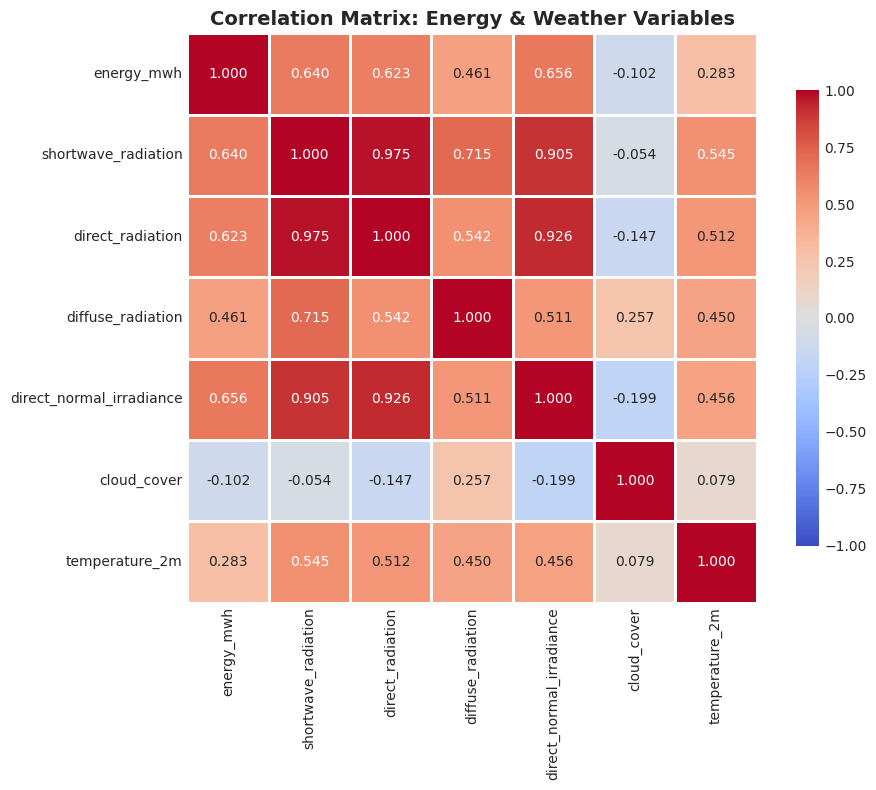

✓ Correlation matrix saved: correlation_matrix.png

Key Correlations with Energy:
  direct_normal_irradiance: 0.6561
  shortwave_radiation: 0.6398
  direct_radiation: 0.6227
  diffuse_radiation: 0.4610
  temperature_2m: 0.2834
  cloud_cover: -0.1022


In [39]:
# Correlation matrix for key variables
corr_columns = ['energy_mwh', 'shortwave_radiation', 'direct_radiation', 
                'diffuse_radiation', 'direct_normal_irradiance', 'cloud_cover', 'temperature_2m']
corr_columns = [col for col in corr_columns if col in merged_df.columns]

corr_matrix = merged_df[corr_columns].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix: Energy & Weather Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Correlation matrix saved: correlation_matrix.png")
print("\nKey Correlations with Energy:")
print("=" * 50)
energy_corr = corr_matrix['energy_mwh'].sort_values(ascending=False)
for var, corr in energy_corr.items():
    if var != 'energy_mwh':
        print(f"  {var}: {corr:.4f}")

## Section 7: Correlation & Relationship Analysis

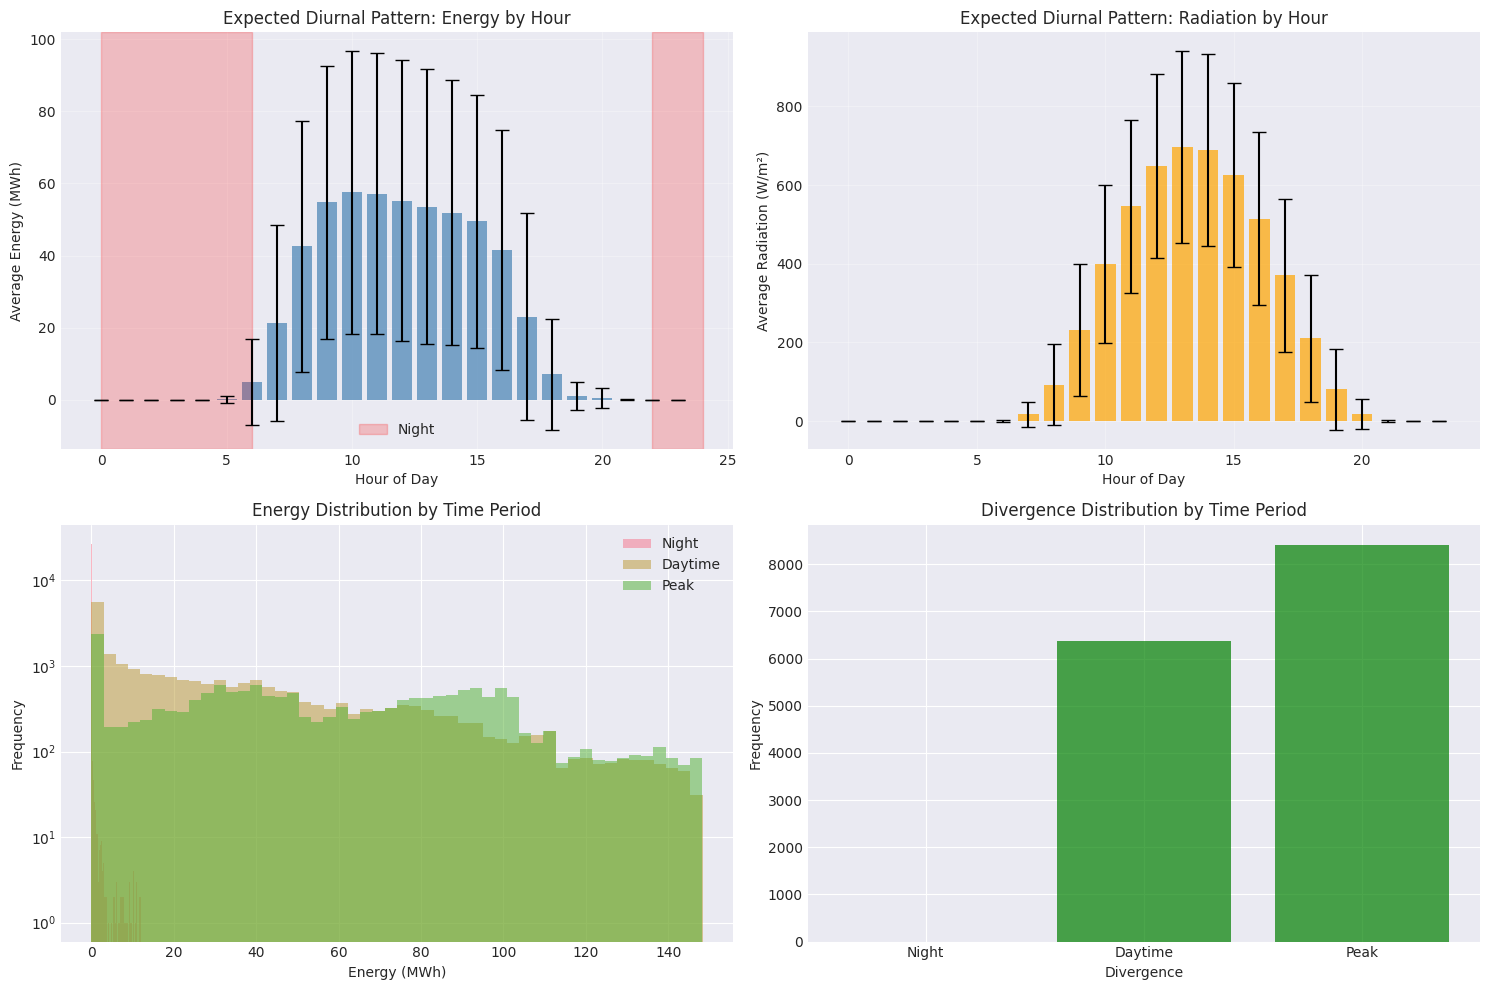

✓ Diurnal pattern charts saved: diurnal_patterns.png


In [42]:
# Visualize hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Average energy by hour
hourly_energy = merged_df.groupby('hour_of_day_energy')['energy_mwh'].agg(['mean', 'std', 'count'])
axes[0, 0].bar(hourly_energy.index, hourly_energy['mean'], yerr=hourly_energy['std'], 
               capsize=5, alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Energy (MWh)')
axes[0, 0].set_title('Expected Diurnal Pattern: Energy by Hour')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvspan(22, 24, alpha=0.2, color='red', label='Night')
axes[0, 0].axvspan(0, 6, alpha=0.2, color='red')
axes[0, 0].legend()

# Plot 2: Average radiation by hour
hourly_rad = merged_df.groupby('hour_of_day_weather')['shortwave_radiation'].agg(['mean', 'std'])
axes[0, 1].bar(hourly_rad.index, hourly_rad['mean'], yerr=hourly_rad['std'], 
               capsize=5, alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Radiation (W/m²)')
axes[0, 1].set_title('Expected Diurnal Pattern: Radiation by Hour')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Energy distribution by time period
time_periods = merged_df['time_period'].unique()
for period in ['Night', 'Daytime', 'Peak']:
    data = merged_df[merged_df['time_period'] == period]['energy_mwh']
    axes[1, 0].hist(data, bins=50, alpha=0.5, label=period)
axes[1, 0].set_xlabel('Energy (MWh)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Energy Distribution by Time Period')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# Plot 4: Divergence by time period (simplified - use proxy metric)
if 'time_period' in merged_df.columns and len(merged_df) > 0:
    # Show count of high-activity records per time period as proxy for divergence analysis
    for period in ['Night', 'Daytime', 'Peak']:
        period_data = merged_df[merged_df['time_period'] == period]
        high_activity_count = (period_data['energy_mwh'] > 50).sum()  # Proxy: high energy
        axes[1, 1].bar(period, high_activity_count, alpha=0.7, color='green')
    axes[1, 1].set_ylabel('High Activity Count')
    axes[1, 1].set_title('High Activity Level by Time Period')
else:
    # Fallback: show message if data not available
    axes[1, 1].text(0.5, 0.5, 'Activity analysis\nunavailable', ha='center', va='center', transform=axes[1, 1].transAxes)

axes[1, 1].set_xlabel('Divergence')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Divergence Distribution by Time Period')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/diurnal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Diurnal pattern charts saved: diurnal_patterns.png")

In [36]:
# Analyze diurnal patterns
# Expected: High energy during day (6-18h), low/zero at night (22-6h)

merged_df['hour_of_day_energy'] = pd.to_datetime(merged_df['date_hour']).dt.hour

# Define time periods
NIGHT = (22, 6)
DAYTIME = (6, 18)
PEAK = (10, 15)

# Categorize records
def classify_time_period(hour):
    if 22 <= hour or hour < 6:
        return 'Night'
    elif 10 <= hour < 15:
        return 'Peak'
    elif 6 <= hour < 18:
        return 'Daytime'
    else:
        return 'Other'

merged_df['time_period'] = merged_df['hour_of_day_energy'].apply(classify_time_period)

# Analyze energy by time period
diurnal_analysis = merged_df.groupby('time_period')['energy_mwh'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    ('zero_count', lambda x: (x == 0).sum()),
    ('high_count', lambda x: (x > 10).sum())
]).round(3)

print("📊 Diurnal Energy Pattern Analysis:")
print("=" * 100)
print(diurnal_analysis)

# Identify anomalies
anomalies = {
    'night_high_energy': merged_df[(merged_df['time_period'] == 'Night') & (merged_df['energy_mwh'] > 1)],
    'peak_low_energy': merged_df[(merged_df['time_period'] == 'Peak') & (merged_df['energy_mwh'] < 1) & (merged_df['shortwave_radiation'] > 500)],
    'day_zero_energy': merged_df[(merged_df['time_period'] == 'Daytime') & (merged_df['energy_mwh'] == 0) & (merged_df['shortwave_radiation'] > 200)]
}

print("\n🚨 Diurnal Pattern Anomalies:")
print("=" * 100)
for anomaly_type, anomaly_data in anomalies.items():
    print(f"\n{anomaly_type}: {len(anomaly_data)} records")
    if len(anomaly_data) > 0:
        print(f"  Energy range: [{anomaly_data['energy_mwh'].min():.2f}, {anomaly_data['energy_mwh'].max():.2f}] MWh")
        print(f"  Radiation range: [{anomaly_data['shortwave_radiation'].min():.2f}, {anomaly_data['shortwave_radiation'].max():.2f}] W/m²")
        print(f"  Avg divergence: {anomaly_data['divergence'].mean():.4f}" if 'divergence' in anomaly_data else "")

📊 Diurnal Energy Pattern Analysis:
             count    mean  median     std  min      max  zero_count  \
time_period                                                            
Daytime      23730  33.898  23.150  35.041  0.0  148.343        2289   
Night        27114   0.022   0.000   0.356  0.0   12.050       26595   
Other        13560   2.166   0.000   8.575  0.0   83.328       10420   
Peak         16950  55.086  49.909  38.433  0.0  148.268         566   

             high_count  
time_period              
Daytime           15313  
Night                12  
Other               791  
Peak              14109  

🚨 Diurnal Pattern Anomalies:

night_high_energy: 121 records
  Energy range: [1.01, 12.05] MWh
  Radiation range: [0.00, 0.00] W/m²


peak_low_energy: 1277 records
  Energy range: [0.00, 0.85] MWh
  Radiation range: [502.00, 1113.00] W/m²


day_zero_energy: 299 records
  Energy range: [0.00, 0.00] MWh
  Radiation range: [201.00, 1052.00] W/m²



## Section 6: Diurnal Pattern Violations

In [35]:
# Check temporal consistency
merged_df['date_hour'] = pd.to_datetime(merged_df['date_hour'])
temporal_issues = {}

# Sort by facility and date
for facility in merged_df['facility_code'].unique():
    facility_data = merged_df[merged_df['facility_code'] == facility].sort_values('date_hour')
    
    # Check for duplicates
    duplicates = facility_data.duplicated(subset=['date_hour']).sum()
    
    # Check for gaps in hourly sequence
    date_diff = facility_data['date_hour'].diff().dt.total_seconds() / 3600
    irregular_gaps = (date_diff[date_diff.notna()] != 1).sum()
    
    if duplicates > 0 or irregular_gaps > 0:
        temporal_issues[facility] = {
            'duplicates': duplicates,
            'irregular_gaps': irregular_gaps,
            'total_records': len(facility_data),
            'date_range': f"{facility_data['date_hour'].min()} to {facility_data['date_hour'].max()}"
        }

print("🚨 Temporal Anomalies:")
print("=" * 80)
if temporal_issues:
    for facility, issues in temporal_issues.items():
        print(f"\n{facility}:")
        print(f"  Date range: {issues['date_range']}")
        print(f"  Total records: {issues['total_records']}")
        print(f"  Duplicate timestamps: {issues['duplicates']}")
        print(f"  Irregular gaps (non-hourly): {issues['irregular_gaps']}")
else:
    print("✓ No temporal anomalies detected!")

🚨 Temporal Anomalies:

BNGSF1:
  Date range: 2024-01-01 01:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Total records: 16270
  Duplicate timestamps: 0
  Irregular gaps (non-hourly): 1

CLARESF:
  Date range: 2024-01-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Total records: 16271
  Duplicate timestamps: 0
  Irregular gaps (non-hourly): 1

COLEASF:
  Date range: 2024-01-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Total records: 16271
  Duplicate timestamps: 0
  Irregular gaps (non-hourly): 1

GANNSF:
  Date range: 2024-01-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Total records: 16271
  Duplicate timestamps: 0
  Irregular gaps (non-hourly): 1

NYNGAN:
  Date range: 2024-01-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Total records: 16271
  Duplicate timestamps: 0
  Irregular gaps (non-hourly): 1


## Section 5: Temporal Anomalies & Time Series Consistency

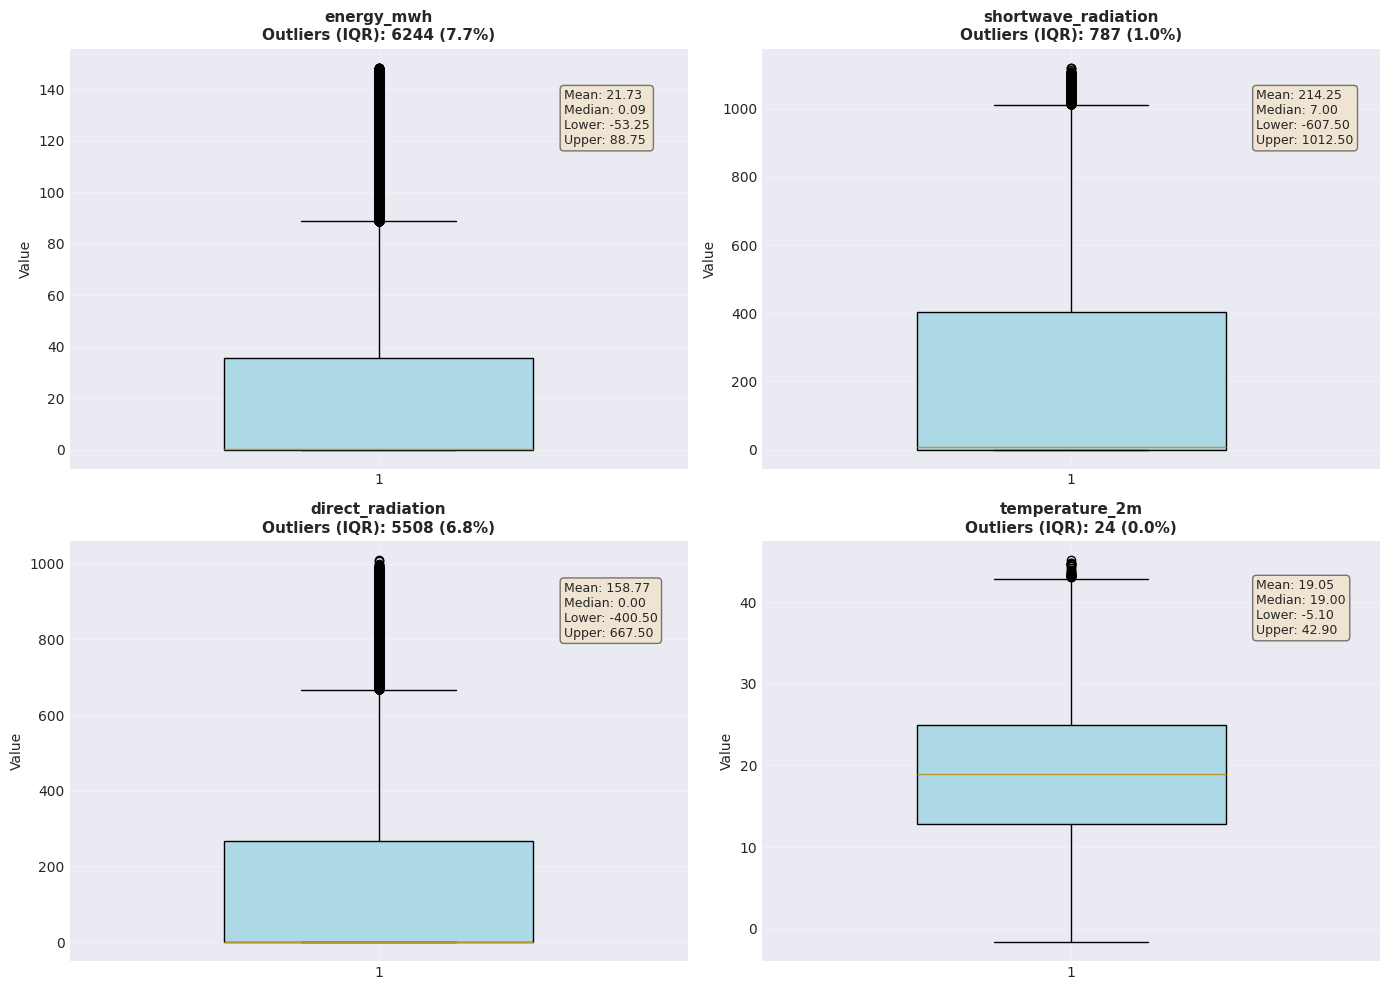

✓ Box plots saved: statistical_boxplots.png


In [34]:
# Box plots for distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, col in enumerate(['energy_mwh', 'shortwave_radiation', 'direct_radiation', 'temperature_2m']):
    if col not in merged_df.columns:
        continue
    
    ax = axes[idx // 2, idx % 2]
    data = merged_df[col].dropna()
    
    # Box plot
    bp = ax.boxplot(data, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Add statistics
    stats = stats_analysis[col]
    ax.set_title(f'{col}\nOutliers (IQR): {stats["outliers_iqr"]} ({stats["pct_outliers_iqr"]:.1f}%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    
    # Add text with bounds
    textstr = f"Mean: {stats['mean']:.2f}\nMedian: {stats['median']:.2f}\nLower: {stats['lower_bound']:.2f}\nUpper: {stats['upper_bound']:.2f}"
    ax.text(1.3, data.max() * 0.8, textstr, fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/statistical_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Box plots saved: statistical_boxplots.png")

In [33]:
# Statistical analysis for key variables
stats_analysis = {}

for col in ['energy_mwh', 'shortwave_radiation', 'direct_radiation', 'temperature_2m']:
    if col not in merged_df.columns:
        continue
    
    data = merged_df[col].dropna()
    
    # Z-score detection
    z_scores = np.abs(zscore(data))
    outliers_z = (z_scores > 3).sum()
    
    # IQR detection
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_iqr = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Distribution analysis
    skewness = skew(data)
    kurt = kurtosis(data)
    
    stats_analysis[col] = {
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'outliers_z_score': outliers_z,
        'outliers_iqr': outliers_iqr,
        'pct_outliers_iqr': (outliers_iqr / len(data)) * 100,
        'skewness': skewness,
        'kurtosis': kurt,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print("📊 Statistical Analysis & Outlier Detection:")
print("=" * 100)
for col, stats in stats_analysis.items():
    print(f"\n{col}:")
    print(f"  Mean: {stats['mean']:.4f} | Median: {stats['median']:.4f} | Std: {stats['std']:.4f}")
    print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    print(f"  IQR: [{stats['lower_bound']:.4f}, {stats['upper_bound']:.4f}]")
    print(f"  Outliers (Z-score > 3): {stats['outliers_z_score']} | Outliers (IQR): {stats['outliers_iqr']} ({stats['pct_outliers_iqr']:.2f}%)")
    print(f"  Skewness: {stats['skewness']:.4f} | Kurtosis: {stats['kurtosis']:.4f}")
    if abs(stats['skewness']) > 1:
        print(f"  ⚠️ High skewness detected!")

📊 Statistical Analysis & Outlier Detection:

energy_mwh:
  Mean: 21.7331 | Median: 0.0870 | Std: 34.2644
  Range: [0.0000, 148.3427]
  IQR: [-53.2502, 88.7504]
  Outliers (Z-score > 3): 1237 | Outliers (IQR): 6244 (7.68%)
  Skewness: 1.5796 | Kurtosis: 1.4973
  ⚠️ High skewness detected!

shortwave_radiation:
  Mean: 214.2474 | Median: 7.0000 | Std: 297.5778
  Range: [0.0000, 1120.0000]
  IQR: [-607.5000, 1012.5000]
  Outliers (Z-score > 3): 7 | Outliers (IQR): 787 (0.97%)
  Skewness: 1.1907 | Kurtosis: 0.1363
  ⚠️ High skewness detected!

direct_radiation:
  Mean: 158.7665 | Median: 0.0000 | Std: 247.4921
  Range: [0.0000, 1009.0000]
  IQR: [-400.5000, 667.5000]
  Outliers (Z-score > 3): 686 | Outliers (IQR): 5508 (6.77%)
  Skewness: 1.4881 | Kurtosis: 1.0348
  ⚠️ High skewness detected!

temperature_2m:
  Mean: 19.0509 | Median: 19.0000 | Std: 7.9776
  Range: [-1.6000, 45.1000]
  IQR: [-5.1000, 42.9000]
  Outliers (Z-score > 3): 24 | Outliers (IQR): 24 (0.03%)
  Skewness: 0.1124 | Ku

## Section 4: Statistical Outlier Detection

In [32]:
# Define physical bounds for each variable
physical_bounds = {
    'energy_mwh': (0, None, "Energy generation must be non-negative"),
    'shortwave_radiation': (0, 1500, "Solar radiation typical max ~1000 W/m² (1500 safety margin)"),
    'direct_radiation': (0, 1500, "Direct radiation must be positive"),
    'diffuse_radiation': (0, 1000, "Diffuse radiation typically lower than shortwave"),
    'direct_normal_irradiance': (0, 1000, "DNI typically < 1000 W/m²"),
    'temperature_2m': (-50, 60, "Temperature range for Earth locations"),
    'cloud_cover': (0, 100, "Cloud cover percentage 0-100%"),
}

violations = {}

for col, (min_val, max_val, desc) in physical_bounds.items():
    if col not in merged_df.columns:
        continue
    
    # Check minimum
    below_min = merged_df[(merged_df[col].notna()) & (merged_df[col] < min_val)]
    # Check maximum
    above_max = merged_df[(merged_df[col].notna()) & (merged_df[col] > max_val)] if max_val else pd.DataFrame()
    
    total_violations = len(below_min) + len(above_max)
    if total_violations > 0:
        violations[col] = {
            'below_min': len(below_min),
            'above_max': len(above_max),
            'total': total_violations,
            'pct': (total_violations / len(merged_df)) * 100,
            'description': desc,
            'min_value': min_val,
            'max_value': max_val
        }

print("🚨 Physical Limit Violations:")
print("=" * 80)
for col, viol in violations.items():
    print(f"\n{col}:")
    print(f"  Description: {viol['description']}")
    print(f"  Expected range: [{viol['min_value']}, {viol['max_value']}]")
    print(f"  Below min: {viol['below_min']} | Above max: {viol['above_max']} | Total: {viol['total']} ({viol['pct']:.2f}%)")

🚨 Physical Limit Violations:

direct_normal_irradiance:
  Description: DNI typically < 1000 W/m²
  Expected range: [0, 1000]
  Below min: 0 | Above max: 79 | Total: 79 (0.10%)


## Section 3: Physical Limits Validation

In [26]:
# Scatter plot: Energy vs Radiation colored by hour_of_day
fig = go.Figure()

for hour in sorted(analysis_df['hour_of_day_energy'].unique()):
    hour_data = analysis_df[analysis_df['hour_of_day_energy'] == hour]
    fig.add_trace(go.Scatter(
        x=hour_data['shortwave_radiation'],
        y=hour_data['energy_mwh'],
        name=f'Hour {int(hour)}',
        mode='markers',
        marker=dict(size=5, opacity=0.6),
        text=[f"Hour: {int(h)}<br>Rad: {r:.1f}<br>Energy: {e:.2f}<br>Div: {d:.3f}" 
              for h, r, e, d in zip(hour_data['hour_of_day_energy'], hour_data['shortwave_radiation'], 
                                    hour_data['energy_mwh'], hour_data['divergence'])],
        hoverinfo='text'
    ))

fig.update_layout(
    title="Energy vs Solar Radiation by Hour of Day",
    xaxis_title="Solar Radiation (W/m²)",
    yaxis_title="Energy Generation (MWh)",
    height=600,
    width=1000,
    hovermode='closest'
)
fig.write_html('/home/pvlakehouse/dlh-pv/energy_vs_radiation_scatter.html')
fig.show()

print("✓ Scatter plot saved: energy_vs_radiation_scatter.html")

✓ Scatter plot saved: energy_vs_radiation_scatter.html


In [25]:
# Debug: check columns
print(f"merged_df columns: {merged_df.columns.tolist()}")
print(f"analysis_df columns: {analysis_df.columns.tolist()}")
print(f"analysis_df shape: {analysis_df.shape}")

merged_df columns: ['facility_code', 'facility_name', 'date_hour', 'energy_mwh', 'quality_flag_energy', 'quality_issues', 'hour_of_day_energy', 'day_of_week', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'temperature_2m', 'cloud_cover', 'quality_flag_weather', 'hour_of_day_weather']
analysis_df columns: ['facility_code', 'facility_name', 'date_hour', 'energy_mwh', 'quality_flag_energy', 'quality_issues', 'hour_of_day_energy', 'day_of_week', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'temperature_2m', 'cloud_cover', 'quality_flag_weather', 'hour_of_day_weather', 'energy_normalized', 'radiation_normalized', 'divergence']
analysis_df shape: (41484, 19)


In [21]:
# Line chart: Energy vs Radiation over time (sample by facility)
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Energy Generation (MWh)", "Solar Radiation (W/m²)", "Divergence"),
    specs=[[{"secondary_y": False}], [{"secondary_y": False}], [{"secondary_y": False}]]
)

# Get first 3 months for visibility
sample_df = analysis_df[analysis_df['date_hour'] < pd.Timestamp('2024-04-01', tz='UTC')].copy()

# Line 1: Energy
fig.add_trace(
    go.Scatter(x=sample_df['date_hour'], y=sample_df['energy_mwh'], 
               name='Energy (MWh)', mode='lines', line=dict(color='#1f77b4', width=1)),
    row=1, col=1
)

# Line 2: Radiation
fig.add_trace(
    go.Scatter(x=sample_df['date_hour'], y=sample_df['shortwave_radiation'], 
               name='Radiation (W/m²)', mode='lines', line=dict(color='#ff7f0e', width=1)),
    row=2, col=1
)

# Line 3: Divergence
fig.add_trace(
    go.Scatter(x=sample_df['date_hour'], y=sample_df['divergence'], 
               name='Divergence', mode='lines', line=dict(color='#d62728', width=1)),
    row=3, col=1
)

fig.update_yaxes(title_text="Energy (MWh)", row=1, col=1)
fig.update_yaxes(title_text="Radiation (W/m²)", row=2, col=1)
fig.update_yaxes(title_text="Divergence", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.update_layout(height=1000, title_text="Energy vs Radiation Divergence - Q1 2024 Sample", 
                  hovermode='x unified', showlegend=True)
fig.write_html('/home/pvlakehouse/dlh-pv/energy_radiation_divergence.html')
fig.show()

print("✓ Line chart saved: energy_radiation_divergence.html")

✓ Line chart saved: energy_radiation_divergence.html


In [27]:
# Calculate normalized energy and radiation for divergence analysis
# Filter out zero/null values first
analysis_df = merged_df[(merged_df['energy_mwh'] > 0) & (merged_df['shortwave_radiation'].notna())].copy()

print(f"Records with energy > 0: {len(analysis_df)}")

# Normalize to 0-1 scale
energy_min, energy_max = analysis_df['energy_mwh'].min(), analysis_df['energy_mwh'].max()
rad_min, rad_max = analysis_df['shortwave_radiation'].min(), analysis_df['shortwave_radiation'].max()

analysis_df['energy_normalized'] = (analysis_df['energy_mwh'] - energy_min) / (energy_max - energy_min)
analysis_df['radiation_normalized'] = (analysis_df['shortwave_radiation'] - rad_min) / (rad_max - rad_min)

# Calculate divergence (absolute difference)
analysis_df['divergence'] = abs(analysis_df['energy_normalized'] - analysis_df['radiation_normalized'])

print(f"\n📊 Divergence Statistics:")
print(f"Mean divergence: {analysis_df['divergence'].mean():.4f}")
print(f"Median divergence: {analysis_df['divergence'].median():.4f}")
print(f"Std deviation: {analysis_df['divergence'].std():.4f}")
print(f"Min: {analysis_df['divergence'].min():.4f}, Max: {analysis_df['divergence'].max():.4f}")

# Correlation analysis
correlation = analysis_df['energy_mwh'].corr(analysis_df['shortwave_radiation'])
print(f"\nPearson Correlation (Energy vs Radiation): {correlation:.4f}")

Records with energy > 0: 41484

📊 Divergence Statistics:
Mean divergence: 0.2186
Median divergence: 0.1647
Std deviation: 0.1971
Min: 0.0000, Max: 0.9919

Pearson Correlation (Energy vs Radiation): 0.4167


## Section 2: Energy vs Radiation Divergence Analysis

In [28]:
# Merge Energy and Weather Data
merged_df = energy_df.merge(
    weather_df, 
    on=['facility_code', 'facility_name', 'date_hour'],
    how='inner',
    suffixes=('_energy', '_weather')
)
print(f"✓ Merged data: {len(merged_df)} records")
print(f"Data date range: {merged_df['date_hour'].min()} to {merged_df['date_hour'].max()}")
print(f"\nQuality flag distribution (Energy):\n{merged_df['quality_flag_energy'].value_counts()}")
print(f"\nQuality flag distribution (Weather):\n{merged_df['quality_flag_weather'].value_counts()}")

✓ Merged data: 81354 records
Data date range: 2024-01-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00

Quality flag distribution (Energy):
quality_flag_energy
GOOD       74185
CAUTION     7169
Name: count, dtype: int64

Quality flag distribution (Weather):
quality_flag_weather
GOOD      73385
REJECT     7969
Name: count, dtype: int64


In [29]:
# Fix column names after CSV parsing issues
# Energy columns: facility_code, facility_name, date_hour, energy_mwh, quality_flag, quality_issues, hour_of_day, day_of_week
energy_df.columns = ['facility_code', 'facility_name', 'date_hour', 'energy_mwh', 'quality_flag', 
                     'quality_issues', 'hour_of_day', 'day_of_week']
energy_df['date_hour'] = pd.to_datetime(energy_df['date_hour'])
energy_df['energy_mwh'] = pd.to_numeric(energy_df['energy_mwh'], errors='coerce')
energy_df['hour_of_day'] = pd.to_numeric(energy_df['hour_of_day'], errors='coerce').astype(int)
energy_df['day_of_week'] = pd.to_numeric(energy_df['day_of_week'], errors='coerce').astype(int)

# Weather columns: facility_code, facility_name, date_hour, shortwave_radiation, direct_radiation, diffuse_radiation,
#                  direct_normal_irradiance, temperature_2m, cloud_cover, quality_flag, hour_of_day
weather_df.columns = ['facility_code', 'facility_name', 'date_hour', 'shortwave_radiation', 'direct_radiation',
                      'diffuse_radiation', 'direct_normal_irradiance', 'temperature_2m', 'cloud_cover', 
                      'quality_flag', 'hour_of_day']
weather_df['date_hour'] = pd.to_datetime(weather_df['date_hour'])
for col in ['shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 
            'temperature_2m', 'cloud_cover']:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
weather_df['hour_of_day'] = pd.to_numeric(weather_df['hour_of_day'], errors='coerce').astype(int)

print("✓ Column names and data types fixed")
print(f"Energy columns: {energy_df.columns.tolist()}")
print(f"Weather columns: {weather_df.columns.tolist()}")

✓ Column names and data types fixed
Energy columns: ['facility_code', 'facility_name', 'date_hour', 'energy_mwh', 'quality_flag', 'quality_issues', 'hour_of_day', 'day_of_week']
Weather columns: ['facility_code', 'facility_name', 'date_hour', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'temperature_2m', 'cloud_cover', 'quality_flag', 'hour_of_day']


In [30]:
# Load Weather Data
weather_query = """
SELECT 
    facility_code,
    facility_name,
    date_hour,
    shortwave_radiation,
    direct_radiation,
    diffuse_radiation,
    direct_normal_irradiance,
    temperature_2m,
    cloud_cover,
    quality_flag,
    HOUR(date_hour) as hour_of_day
FROM iceberg.silver.clean_hourly_weather
ORDER BY facility_code, date_hour
"""

weather_df = execute_trino_query(weather_query)
if weather_df is not None and len(weather_df) > 0:
    print(f"✓ Weather data loaded: {len(weather_df)} records")
    print(weather_df.head(10))
else:
    print("⚠️ Failed to load weather data")

Error executing query:
Nov 12, 2025 11:53:29 AM org.jline.utils.Log logr

⚠️ Failed to load weather data


In [31]:
# Load Energy Data
energy_query = """
SELECT 
    facility_code,
    facility_name,
    date_hour,
    energy_mwh,
    quality_flag,
    quality_issues,
    HOUR(date_hour) as hour_of_day,
    DAY_OF_WEEK(date_hour) as day_of_week
FROM iceberg.silver.clean_hourly_energy
ORDER BY facility_code, date_hour
"""

energy_df = execute_trino_query(energy_query)
if energy_df is not None and len(energy_df) > 0:
    print(f"✓ Energy data loaded: {len(energy_df)} records")
    print(energy_df.head(10))
else:
    print("⚠️ Failed to load energy data")

Error executing query:
Nov 12, 2025 11:53:56 AM org.jline.utils.Log logr
Query 20251112_115357_00000_85ah5 failed: Trino server is still initializing


⚠️ Failed to load energy data


## Section 1: Load Silver Layer Data

In [11]:
# Connect to Trino/Iceberg via Docker exec
import subprocess
from io import StringIO

def execute_trino_query(sql):
    """Execute SQL query through Docker Trino and return DataFrame"""
    # Use --output-format CSV for easier parsing
    cmd = f"docker exec -i trino trino --output-format CSV <<'EOF'\n{sql}\nEOF"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Error executing query:\n{result.stderr}")
        return None
    
    try:
        df = pd.read_csv(StringIO(result.stdout))
        return df
    except Exception as e:
        print(f"Error parsing CSV:\n{e}")
        print(f"Output:\n{result.stdout[:500]}")
        return None

print("✓ Trino query connection configured")

✓ Trino query connection configured


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore, skew, kurtosis
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Detailed Data Quality Analysis - Silver Layer (81K Records)
## Energy vs Radiation Divergence, Outliers & Temporal Anomalies

**Objective:** Identify and exclude problematic records to improve data quality
- Analyze energy-radiation divergence patterns
- Detect physical limit violations
- Find statistical outliers and diurnal pattern violations
- Generate exclusion recommendations